## The score for the sample file is 0.37053 (Cover_type all = 1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train = pd.read_csv('data/forest_train.csv')
test = pd.read_csv('data/forest_test.csv')

train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


* No missing values

# All data are numerical, thus try to predict without touching the data and see how much the score could be

In [2]:
from sklearn.neighbors import KNeighborsClassifier

x_train = train.drop('Cover_Type', axis=1)
y_train = train.Cover_Type
x_test = test
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
y_test = knn.predict(x_test)

In [3]:
# Predicted Cover_Type in unprocessed data only contains type 1,2,3,6,7
unique, counts = np.unique(y_test, return_counts=True)
(unique, counts)

(array([1, 2, 3, 6, 7], dtype=int64),
 array([ 25750,   2593, 526555,   7512,   3482], dtype=int64))

In [4]:
from collections import OrderedDict
submission_unproc = OrderedDict([('Id', test.Id), ('Cover_Type', y_test)])
submission_unproc = pd.DataFrame.from_dict(submission_unproc)
submission_unproc.to_csv('submission/forest_unproc_submi.csv', index=False)

## The unprocessed submission has a really low score of 0.07076 => Processing the data is necessary

# Start processing data

In [5]:
unique, counts = np.unique(train.Cover_Type, return_counts=True)
(unique, counts) # equal number of Type

(array([1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([2160, 2160, 2160, 2160, 2160, 2160, 2160], dtype=int64))

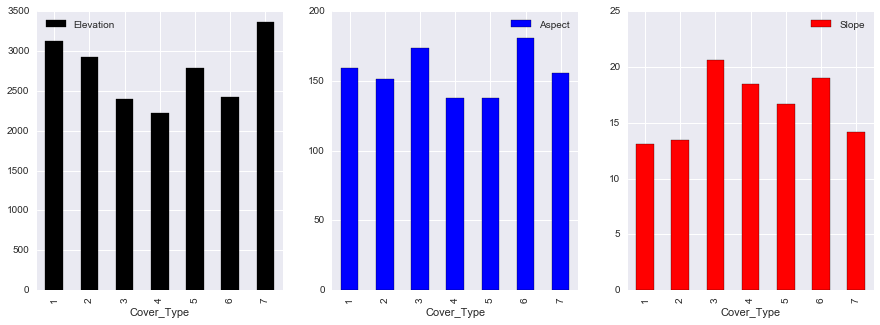

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
train[['Cover_Type', 'Elevation']].groupby(['Cover_Type']).mean().plot(kind='bar', ax=ax1, color='k')
train[['Cover_Type', 'Aspect']].groupby(['Cover_Type']).mean().plot(kind='bar', ax=ax2, color='b')
train[['Cover_Type', 'Slope']].groupby(['Cover_Type']).mean().plot(kind='bar', ax=ax3, color='r')

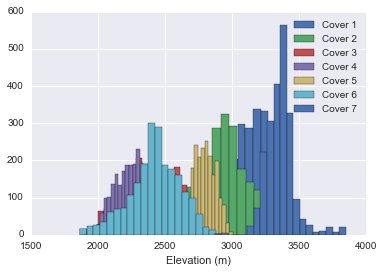

In [7]:
label=['Cover ' + str(x) for x in range(1,8)]
for i in range(7):
    ax = plt.hist(train.Elevation[train.Cover_Type==i+1],label=label[i], bins=20,stacked=True)
plt.legend()
plt.xlabel('Elevation (m)')

### => Only the elevation enables to distinguish types 4,5,7

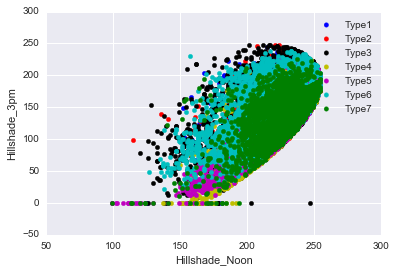

In [8]:
colors = ['b','r','k','y','m','c','g']
for i in range(7):
    plt.scatter(train.Hillshade_Noon[train.Cover_Type==i+1], train.Hillshade_3pm[train.Cover_Type==i+1], color=colors[i], label='Type' +str(i+1))
plt.xlabel('Hillshade_Noon')
plt.ylabel('Hillshade_3pm')
plt.legend()


### A lot a 0 values (which are considered as missing values) for Hillshade_3pm

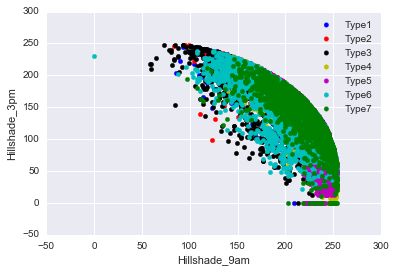

In [9]:
for i in range(7):
    plt.scatter(train.Hillshade_9am[train.Cover_Type==i+1], train.Hillshade_3pm[train.Cover_Type==i+1], color=colors[i], label='Type' +str(i+1))
plt.xlabel('Hillshade_9am')
plt.ylabel('Hillshade_3pm')
plt.legend()

### Only 1 outlier (the 0 value)

## First try prediction with only 3 features (Elevation, Aspect, Slope)

In [10]:
x_train = train[['Elevation', 'Aspect', 'Slope']]
y_train = train.Cover_Type
x_test = test[['Elevation', 'Aspect', 'Slope']]
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_test = knn.predict(x_test)

submission001 = OrderedDict([('Id', test.Id), ('Cover_Type', y_test)])
submission001 = pd.DataFrame.from_dict(submission001)
submission001.to_csv('submission/forest_submission001.csv', index=False)

### With only these 3 features, the submission001 score is = 0.48750

## Distance to Water : combine the horizontal and vertical value into one column of dist_to_water

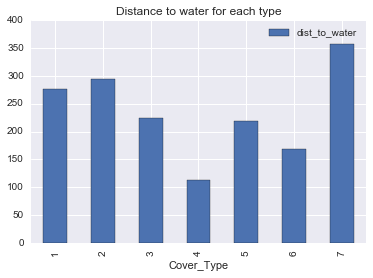

In [11]:
dist_to_water = train.loc[:, ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)
dist_to_water_test = test.loc[:, ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)

dist_to_water = pd.DataFrame(dist_to_water, columns=['dist_to_water'])
dist_to_water_test = pd.DataFrame(dist_to_water_test, columns=['dist_to_water_test'])

train = pd.concat([train, dist_to_water], axis=1)
test = pd.concat([test, dist_to_water_test], axis=1)

train[['Cover_Type', 'dist_to_water']].groupby('Cover_Type').mean().plot(kind='bar', title='Distance to water for each type')

In [12]:
x_train = train[['Elevation', 'Aspect', 'Slope', 'dist_to_water']]
y_train = train.Cover_Type
x_test = test[['Elevation', 'Aspect', 'Slope', 'dist_to_water_test']]

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_test = knn.predict(x_test)

submission002 = OrderedDict([('Id', test.Id), ('Cover_Type', y_test)])
submission002 = pd.DataFrame.from_dict(submission002)
submission002.to_csv('submission/forest_submission002.csv', index=False)

* Combining the horizontal and vertical into one coloumn result in a score of 0.51874
* Not combining these columns result in score of 0.53955 .... => Not useful to combine ?!

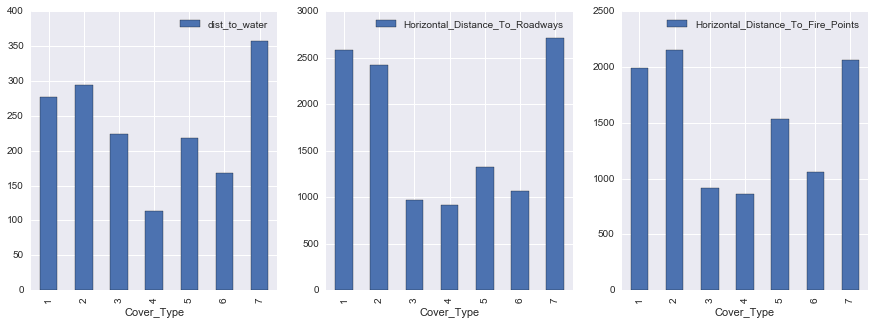

In [13]:
# Distance to road and Fire point
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
train[['Cover_Type', 'dist_to_water']].groupby('Cover_Type').mean().plot(kind='bar', ax=ax1)
train[['Cover_Type', 'Horizontal_Distance_To_Roadways']].groupby('Cover_Type').mean().plot(kind='bar', ax=ax2)
train[['Cover_Type', 'Horizontal_Distance_To_Fire_Points']].groupby('Cover_Type').mean().plot(kind='bar', ax=ax3)

### Type 3,4,5,6 are closer to water, road and firepoints

## Hillshade index

In [14]:
# combine the 3 values as a mean
hillshade_mean = train[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
hillshade_mean = pd.DataFrame(hillshade_mean, columns=['hillshade_mean'])

hillshade_mean_test = test[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
hillshade_mean_test = pd.DataFrame(hillshade_mean_test, columns=['hillshade_mean_test'])

train = pd.concat([train, hillshade_mean], axis=1)
test = pd.concat([test, hillshade_mean_test], axis=1)

## Wilderness Area

In [15]:
# categorize the 4 columns into 1 single column 
def categorize(df, cols_name):
    for k in range(df.shape[1]):
        df[cols_name+str(k+1)] = df.loc[:, cols_name+str(k+1)].map({1:k+1, 0:0})
    return df

wilderness = train.loc[:, 'Wilderness_Area1': 'Wilderness_Area4']
wilderness = categorize(wilderness, 'Wilderness_Area')
wilderness = wilderness.sum(axis=1).astype('category')
train = pd.concat([train, wilderness], axis=1)

wilderness_test = test.loc[:, 'Wilderness_Area1': 'Wilderness_Area4']
wilderness_test = categorize(wilderness_test, 'Wilderness_Area')
wilderness_test = wilderness_test.sum(axis=1).astype('category')
test = pd.concat([test, wilderness_test], axis=1)

## Soil type

In [16]:
# categorize the 40 columns into 1 single column 

soil = train.loc[:, 'Soil_Type1': 'Soil_Type40']
soil = categorize(soil, 'Soil_Type')
soil = soil.sum(axis=1).astype('category')
soil = pd.DataFrame(soil, columns=['soil'])
train = pd.concat([train, soil], axis=1)

soil_test = test.loc[:, 'Soil_Type1': 'Soil_Type40']
soil_test = categorize(soil_test, 'Soil_Type')
soil_test = soil_test.sum(axis=1).astype('category')
soil_test = pd.DataFrame(soil_test, columns=['soil_test'])
test = pd.concat([test, soil_test], axis=1)

### Prediction using KNN 

In [17]:
x_train = train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'dist_to_water', 'Hillshade_Noon', 'Hillshade_3pm', 'Hillshade_9am', 'soil']]
y_train = train.Cover_Type
x_test = test[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'dist_to_water_test', 'Hillshade_Noon', 'Hillshade_3pm', 'Hillshade_9am', 'soil_test']]

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_test = knn.predict(x_test)

submission003 = OrderedDict([('Id', test.Id), ('Cover_Type', y_test)])
submission003 = pd.DataFrame.from_dict(submission003)
submission003.to_csv('submission/forest_submission003.csv', index=False)

## Submission003 using KNN (combining dist_to_water, hillshade_index, categorized wilderness area and soil types) : score = 0.63445

### Prediction using Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

x_train = train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'dist_to_water', 'Hillshade_Noon', 'Hillshade_3pm', 'Hillshade_9am', 'soil']]
y_train = train.Cover_Type
x_test = test[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'dist_to_water_test', 'Hillshade_Noon', 'Hillshade_3pm', 'Hillshade_9am', 'soil_test']]

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_test = rf.predict(x_test)

submission004 = OrderedDict([('Id', test.Id), ('Cover_Type', y_test)])
submission004 = pd.DataFrame.from_dict(submission004)
submission004.to_csv('submission/forest_submission004.csv', index=False)

### With the same cleaned dataset, and using *Random Forest* (instead of KNN), the score get is 0.0.71449.

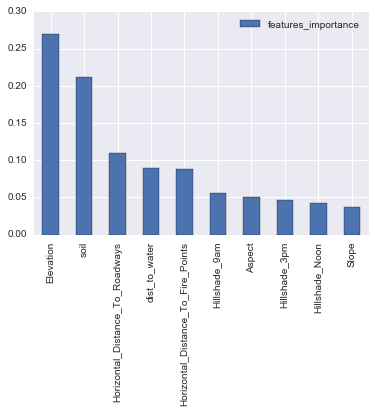

In [19]:
# Plot the features importances
feat_importance_df = pd.DataFrame(rf.feature_importances_, index=x_train.columns, columns=['features_importance'])
feat_importance_df.sort_values(by='features_importance', ascending=False).plot(kind='bar')


### As expected, the importance of the features Elevation is the highest one.

### Confusion matrix for the training dataset (which has an excellent prediction score) 

Confusion matrix, without normalization


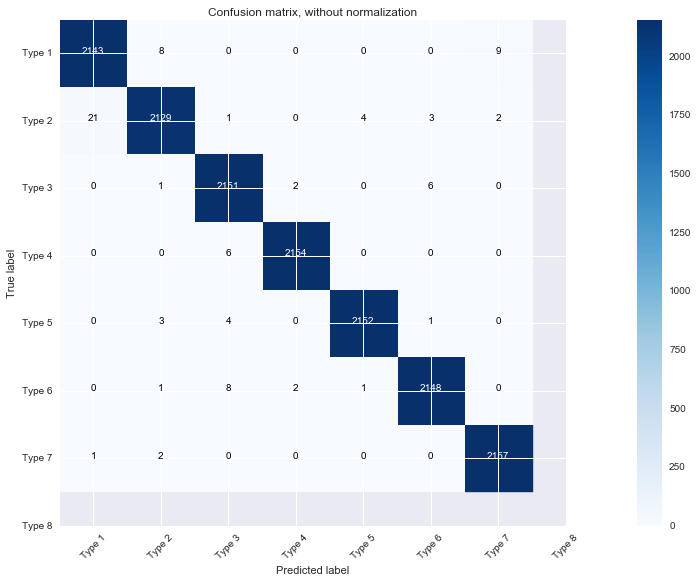

In [20]:
from sklearn.metrics import confusion_matrix
import itertools

y_pred = rf.predict(x_train)
cnf_matrix = confusion_matrix(y_train, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plt.figure(figsize=(20, 8))
plot_confusion_matrix(cnf_matrix, classes=['Type '+str(i+1) for i in range(8)], title='Confusion matrix, without normalization')


### => Only Type 1 and 2 are difficult to predict